## Import necessary Libraries ##

In [2]:
#import necessary libraries 
import tensorflow as tf 
import numpy as np 
from datetime import datetime 
import shutil

from tensorflow import data
from tensorflow.contrib.learn import learn_runner
from tensorflow.contrib.learn import make_export_strategy

## Some Visualizations and Insights about the Data ##

In [73]:
df = pd.read_csv("dummy_dataset.csv", names=['Recency','Frequency', 'Montary'])
df.head()

,Recency,Frequency,Montary
0,3.0,5.0,1.0
1,7.0,9.0,2.0
2,5.0,3.0,9.0
3,1.0,5.0,5.0
4,5.0,7.0,7.0


In [80]:
import plotly.plotly as py
import plotly.figure_factory as ff

# Add histogram data
x1 = df['Recency']
x2 = df['Montary']  
x3 = df['Frequency'] 

# Group data together
hist_data = [x1]

group_labels = ['Recency Group']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size= .5)

# Plot!
py.iplot(fig, filename='Distplot with Recency value')

The draw time for this plot will be slow for clients without much RAM.


c:\users\madhivarman\appdata\local\programs\python\python35\lib\site-packages\plotly\api\v1\clientresp.py:40: UserWarning:

Estimated Draw Time Slow



From the above graph we can say that that are lot distribtion of data by calculating Frequency of that Range. For example, from above graph we can say that almost all range values are equally distributed.

In [81]:
# Group data together
hist_data = [x2]

group_labels = ['Montary Group']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size= .5)

# Plot!
py.iplot(fig, filename='Distplot with Montary value')

The draw time for this plot will be slow for clients without much RAM.


c:\users\madhivarman\appdata\local\programs\python\python35\lib\site-packages\plotly\api\v1\clientresp.py:40: UserWarning:

Estimated Draw Time Slow



Since this is randomly generated data, the distribution will be almost equal in all the range points.

## Data Preprocessing and Defining Parameters##

In [3]:
#read the dataset
train_filename = ["dummy_dataset.csv"]
test_filename = ["dummy_dataset_test.csv"]

model_name = "cluster-01"

resume = False
train = True

In [4]:
#print column values
HEADER = ['Unamed:0','Frequency','Recency', 'Monetary']
HEADER_DEFAULTS = [[0],[0.0],[0.0],[0.0]]
FEATURE_NAMES = ['Frequency','Monetary','Recency']
UNUSED_FEATURE_NAMES = list(set(HEADER) - set(FEATURE_NAMES))

print("Input features we have selected:{features}"
		.format(features=FEATURE_NAMES))
print("Unused Features:{}".format(UNUSED_FEATURE_NAMES))

Input features we have selected:['Frequency', 'Monetary', 'Recency']
Unused Features:['Unamed:0']


### a. Parsing and Pre-processing Logic###

In [5]:
#parsing and preprocessing logic
def parse_csv_row(csv_row):
	#decode csv, convert dataset into tensor
	columns = tf.decode_csv(csv_row, record_defaults=HEADER_DEFAULTS)
	columns = [tf.expand_dims(tensor, -1) for tensor in columns]
	features = dict(zip(HEADER, columns))

	for column in UNUSED_FEATURE_NAMES:
		features.pop(column)

	return features

def process_features(features):

	if process_features:
		features = features

	return features


### b. Data Pipeling input Function ###

In [6]:
#data pipeline input function
def csv_input_fn(file_names, mode=tf.estimator.ModeKeys.TRAIN,
				skip_header_lines = 0,
				num_epochs=None,
				batch_size=200):

		shuffle = False
		print("Data Input Function")
		print("=====================")
		print("Batch_Size:{}".format(batch_size))
		print("Epoch Count:{}".format(num_epochs))
		print("Shuffle:{}".format(shuffle))
		print("============================")

		dataset = data. TextLineDataset(filenames= train_filename)
		dataset = dataset.skip(skip_header_lines)

		if shuffle:
			dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)

		dataset = dataset.batch(batch_size)
		dataset = dataset.map(lambda csv_row: parse_csv_row(csv_row))
		dataset = dataset.map(lambda features: process_features(features))

		dataset = dataset.repeat(num_epochs)
		iterator = dataset.make_one_shot_iterator()

		features = iterator.get_next()

		return features, None

In [7]:
features, _ = csv_input_fn(file_names = train_filename)
print("Features read from CSV:{}".format(list(features.keys())))

Data Input Function
Batch_Size:200
Epoch Count:None
Shuffle:False
Features read from CSV:['Recency', 'Monetary', 'Frequency']


### Build an Estimator ###

In [8]:
#build an estimator
def create_estimator(run_config, hparams):
	estimator = tf.contrib.learn.KMeansClustering(
        num_clusters = hparams.num_clusters,
        initial_clusters= tf.contrib.factorization.RANDOM_INIT,
        distance_metric= tf.contrib.factorization.SQUARED_EUCLIDEAN_DISTANCE,
        use_mini_batch=True,
        mini_batch_steps_per_iteration=1,
        kmeans_plus_plus_num_retries=10,
        relative_tolerance=None,
        config= run_config
    )

	print("")
	print("Estimator Type:{}".format(type(estimator)))

	return estimator

## Run a Experiment ##

## A. creating a Serve Input Function in Updated Function ##

In [9]:
def csv_serving_input_fn_vtwo():
    feature_placeholders = {
        'renancy': tf.placeholder(tf.float32, [None]),
        'freq': tf.placeholder(tf.float32, [None]),
        'monetary': tf.placeholder(tf.float32, [None])
    }
    features ={
        key: tf.expand_dims(tensor, -1)
        for key, tensor in feature_placeholders.items()
    }
    
    return tf.contrib.learn.InputFnOps(features, None, feature_placeholders)

### b. Create Experiment Function ###

In [10]:
def generate_experiment_fn(**experiment_args):
    
    def _experiment_fn(run_config, hparams):
        
        train_input_fn = lambda: csv_input_fn(
            train_filename,
            mode = tf.contrib.learn.ModeKeys.TRAIN,
            num_epochs = hparams.num_epochs,
            batch_size = hparams.batch_size*10
        )
        
        eval_input_fn = lambda: csv_input_fn(
            train_filenames,
            mode = tf.contrib.learn.ModeKeys.EVAL,
            num_epochs=1,
            batch_size=hparams.batch_size
        )
        
        estimator = create_estimator(run_config, hparams)
        
        return tf.contrib.learn.Experiment(
            estimator,
            train_input_fn = train_input_fn,
            eval_input_fn = eval_input_fn,
            eval_steps = None,
            **experiment_args
        )
    
    return _experiment_fn

## creating Hyperparameter Tuning ##

In [11]:
#set HParam and RunConfig
hparams = tf.contrib.training.HParams(
	num_epochs=1000,
	batch_size=500,
	num_clusters=3)

model_dir = "trained_models/{}".format(model_name)

run_config = tf.contrib.learn.RunConfig(
	save_checkpoints_steps=100,
	tf_random_seed=100000,
	model_dir = model_dir)

print("Model is Stored in Directory:{}".format(run_config.model_dir))

Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
Model is Stored in Directory:trained_models/cluster-01


### d.Run Experiement ###

In [12]:
if not resume:
	print("Removing Previous Artifacts....")
	shutil.rmtree(model_dir, ignore_errors=True)
else:
	print("Resuming Training....")


if train:
	tf.logging.set_verbosity(tf.logging.INFO)
	time_start = datetime.utcnow()
	print("Training Started at {}".format(time_start.strftime("%H:%M:%S")))
	print(".......................................")

	learn_runner.run(
        experiment_fn = generate_experiment_fn(
            
            export_strategies=[make_export_strategy(
               csv_serving_input_fn_vtwo,
                exports_to_keep =1
            )]
        ), #not executing export_savedmodel()
        run_config = run_config,
        schedule="train",
        hparams=hparams
    ) 

	time_end = datetime.utcnow()
	print(".......................................")
	print("Training Finished at {}".format(time_end. strftime("%H:%M:%S")))
	print("")

	time_elapsed = time_end - time_start
	print("Training elapsed time:{} Seconds".format(time_elapsed.total_seconds()))

Removing Previous Artifacts....
Training Started at 07:14:06
.......................................
Instructions for updating:
Switch to tf.estimator.Exporter and associated utilities.
Instructions for updating:
Please switch to tf.estimator.train_and_evaluate, and use tf.estimator.Exporter.
Instructions for updating:
Use tf.estimator.train_and_evaluate.
Instructions for updating:
Please use tf.contrib.factorization.KMeansClustering instead of tf.contrib.learn.KMeansClustering. It has a similar interface, but uses the tf.estimator.Estimator API instead of tf.contrib.learn.Estimator.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_device_fn': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021C041DFAC8>, '_train_distribute': None, '_model_dir': 'trained_models/cluster-01', '_keep_checkpoint_every_n_hours': 1

INFO:tensorflow:global_step/sec: 52.6134
INFO:tensorflow:loss = 59819.508, step = 2201 (1.900 sec)
INFO:tensorflow:Saving checkpoints for 2300 into trained_models/cluster-01\model.ckpt.
INFO:tensorflow:global_step/sec: 52.1055
INFO:tensorflow:loss = 60116.29, step = 2301 (1.919 sec)
INFO:tensorflow:Saving checkpoints for 2400 into trained_models/cluster-01\model.ckpt.
INFO:tensorflow:global_step/sec: 46.957
INFO:tensorflow:loss = 59817.625, step = 2401 (2.130 sec)
INFO:tensorflow:Saving checkpoints for 2500 into trained_models/cluster-01\model.ckpt.
INFO:tensorflow:global_step/sec: 52.3424
INFO:tensorflow:loss = 60114.387, step = 2501 (1.911 sec)
INFO:tensorflow:Saving checkpoints for 2600 into trained_models/cluster-01\model.ckpt.
INFO:tensorflow:global_step/sec: 47.4623
INFO:tensorflow:loss = 59816.176, step = 2601 (2.108 sec)
INFO:tensorflow:Saving checkpoints for 2700 into trained_models/cluster-01\model.ckpt.
INFO:tensorflow:global_step/sec: 54.2417
INFO:tensorflow:loss = 60112.86

INFO:tensorflow:loss = 59790.734, step = 6601 (1.966 sec)
INFO:tensorflow:Saving checkpoints for 6700 into trained_models/cluster-01\model.ckpt.
INFO:tensorflow:global_step/sec: 43.5885
INFO:tensorflow:loss = 60089.77, step = 6701 (2.293 sec)
INFO:tensorflow:Saving checkpoints for 6800 into trained_models/cluster-01\model.ckpt.
INFO:tensorflow:global_step/sec: 43.7719
INFO:tensorflow:loss = 59789.633, step = 6801 (2.285 sec)


KeyboardInterrupt: 

## Perform Predictions ##

In [13]:
#perform predictions
train_input_fn = lambda: csv_input_fn(
	train_filename,
	num_epochs=1,
	batch_size=1500)

test_input_fn = lambda: csv_input_fn(
    test_filename,
    num_epochs=1,
    batch_size = 500
    )

estimator = create_estimator(run_config, hparams)


train_assignments = list(estimator.predict_cluster_idx(input_fn=train_input_fn))
test_assignments = list(estimator.predict_cluster_idx(input_fn=test_input_fn))

INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_device_fn': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021C041DFAC8>, '_train_distribute': None, '_model_dir': 'trained_models/cluster-01', '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_is_chief': True, '_save_checkpoints_steps': 100, '_num_worker_replicas': 0, '_session_config': None, '_task_id': 0, '_task_type': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_save_checkpoints_secs': None, '_tf_random_seed': 100000, '_evaluation_master': '', '_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_environment': 'local'}

Estimator Type:<class 'tensorflow.contrib.learn.python.learn.estimators.kmeans.KMeansClustering'>
Instructions for updating:
Please use tf.contrib.factorization.KMeansClustering instead of tf.contrib.learn.KMeansClustering. It has a similar interface, but uses the tf.estimator.Estimator API inst

In [14]:
#print cluster centroids
clusters = estimator.clusters()
print("Cluster Centroids:")
print("=====================")
print(clusters)

Instructions for updating:
Please use tf.contrib.factorization.KMeansClustering instead of tf.contrib.learn.KMeansClustering. It has a similar interface, but uses the tf.estimator.Estimator API instead of tf.contrib.learn.Estimator.
Cluster Centroids:
[[2.3343518 5.593164  4.7040625]
 [6.9619203 7.1915007 5.074513 ]
 [6.045362  2.396631  5.2708364]]


## Serving via the Saved model ##

In [17]:
model_dir = 'F:/work projects/customer_segmentation/TensorFlowModel'
export_dir = model_dir + "/serve_fn_two"
estimator.export_savedmodel(export_dir, csv_serving_input_fn_vtwo)

Instructions for updating:
Switch to tf.estimator.Exporter and associated utilities.
Instructions for updating:
Switch to tf.estimator.Exporter and associated utilities.
Instructions for updating:
Switch to tf.estimator.Exporter and associated utilities.
Instructions for updating:
Switch to tf.estimator.Exporter and associated utilities.
INFO:tensorflow:Restoring parameters from trained_models/cluster-01\model.ckpt-6800
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: F:/work projects/customer_segmentation/TensorFlowModel/serve_fn_two\temp-1540797637\saved_model.pb


b'F:/work projects/customer_segmentation/TensorFlowModel/serve_fn_two\\1540797637'

## Visualizations ##

In [54]:
prediction = estimator.predict(input_fn= test_input_fn)
prediction

Data Input Function
Batch_Size:500
Epoch Count:1
Shuffle:False
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from trained_models/cluster-01\model.ckpt-6800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<generator object BaseEstimator._predict_generator at 0x0000021C67C75728>

In [53]:
for i in prediction:
    print(i)

{'all_scores': array([21.627823, 54.03704 , 11.298164], dtype=float32), 'cluster_idx': 2}
{'all_scores': array([53.13417 , 42.362587, 14.975311], dtype=float32), 'cluster_idx': 2}
{'all_scores': array([21.616043 , 11.4234085, 49.85396  ], dtype=float32), 'cluster_idx': 1}
{'all_scores': array([ 2.2199097, 40.352715 , 32.306564 ], dtype=float32), 'cluster_idx': 0}
{'all_scores': array([14.356201,  7.593315, 25.273804], dtype=float32), 'cluster_idx': 1}
{'all_scores': array([54.569305, 12.906761, 54.873444], dtype=float32), 'cluster_idx': 1}
{'all_scores': array([ 3.0688324, 25.888039 , 11.918381 ], dtype=float32), 'cluster_idx': 0}
{'all_scores': array([32.355453, 13.648598, 54.304916], dtype=float32), 'cluster_idx': 1}
{'all_scores': array([ 3.4769592, 27.037071 , 13.4600525], dtype=float32), 'cluster_idx': 0}
{'all_scores': array([63.051468, 20.982903, 35.62082 ], dtype=float32), 'cluster_idx': 1}
{'all_scores': array([ 9.031021, 39.28866 , 49.63669 ], dtype=float32), 'cluster_idx': 0

So now the result will be stored in an memory object. To get the prediction Scores we need to iterate through the generator object. The type of the iterator object is **dictionary**. Where you can get the **X,Y,Z** coordinates in key name 'all_scores'

In [55]:
coordinates, clusters = [], []

for i in prediction:
    #iterate through the dict
    coordinates.append(i['all_scores'])
    clusters.append(i['cluster_idx'])

In [56]:
X_points = [i[0] for i in coordinates]
Y_points = [i[1] for i in coordinates]
Z_points = [i[2] for i in coordinates]

print(len(X_points), len(Y_points), len(Z_points))

500 500 500


(39999, 4)


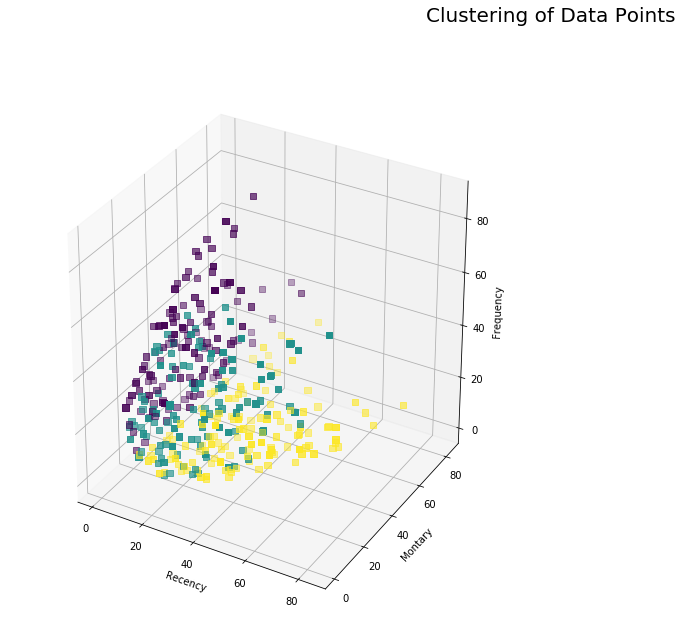

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

train_df = pd.read_csv('dummy_dataset.csv')
test_df = pd.read_csv('dummy_dataset_test.csv')

fig = plt.figure()

print(train_df.shape)

ax = fig.add_subplot(121, projection='3d')

ax.scatter(X_points,Y_points,Z_points, marker="s", c=clusters, s=40)

ax.set_xlabel('Recency')
ax.set_ylabel('Montary')
ax.set_zlabel('Frequency')


fig.set_size_inches(20,10)
fig.suptitle('Clustering of Data Points', fontsize=20)

plt.show()

In [70]:
fig.savefig('3d_Clustering_Image.png') #saving the image